<a href="https://colab.research.google.com/github/VictorFu0717/AI/blob/main/HeartAttackPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 連接kaggle api
api_token = {"username":"victor830717","key":"e5ff0036288b15a13b2e2e4444e5051b"}
import json
import zipfile
import os

# 建資料夾 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
# !kaggle datasets download -d {kaggle資料集名稱} --force
!kaggle datasets download -d rashikrahmanpritom/heart-attack-analysis-prediction-dataset --force
 
!ls /kaggle

  0% 0.00/4.11k [00:00<?, ?B/s]
100% 4.11k/4.11k [00:00<00:00, 3.86MB/s]
heart-attack-analysis-prediction-dataset.zip


In [2]:
! unzip heart-attack-analysis-prediction-dataset.zip 

Archive:  heart-attack-analysis-prediction-dataset.zip
  inflating: heart.csv               
  inflating: o2Saturation.csv        


In [3]:
#Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
import seaborn as sns
import matplotlib.pyplot as plt

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [4]:
data = pd.read_csv('heart.csv')
data

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


age：患者年齡

sex：患者的性別

exang：運動誘發的心絞痛（1 = 是；0 = 否）

ca：主要血管的數量（0-3）

cp : 胸痛型 胸痛型

  Value 0：典型心絞痛
  Value 1：非典型心絞痛
  Value 2：非心絞痛
  Value 3：無症狀

trtbps : 靜息血壓 (mm Hg)

chol ：通過 BMI 傳感器獲取的以 mg/dl 為單位的膽甾醇

fbs : (空腹血糖 > 120 mg/dl) (1 = true; 0 = false)

rest_ecg : 靜息心電圖結果

  Value 0：正常
  Value 1：ST-T 波異常（T 波倒置和/或 ST 升高或降低 > 0.05 mV）
  Value 2：根據 Estes 標準顯示可能或確定的左心室肥大

thalach：達到的最大心率

target：0 = 心髒病發作的機會減少 1 = 心髒病發作的機會增加

oldpeak : 上一個高峰



In [25]:
data.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [5]:
x = data.drop('output',axis=1)
y = data['output']
x

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3


In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15)
x_train

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
99,53,1,2,130,246,1,0,173,0,0.0,2,3,2
124,39,0,2,94,199,0,1,179,0,0.0,2,0,2
17,66,0,3,150,226,0,1,114,0,2.6,0,0,2
62,52,1,3,118,186,0,0,190,0,0.0,1,0,1
107,45,0,0,138,236,0,0,152,1,0.2,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,53,0,2,128,216,0,0,115,0,0.0,2,0,0
157,35,1,1,122,192,0,1,174,0,0.0,2,0,2
148,44,1,2,120,226,0,1,169,0,0.0,2,0,2
220,63,0,0,150,407,0,0,154,0,4.0,1,3,3


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier()
params = {
    "n_estimators":range(3, 100, 2),
    "max_depth":range(5, 11)
}
#GridSearch函式：利用交叉驗證幫你調出最佳參數
grid = GridSearchCV(clf, params, cv=10, n_jobs=-1, scoring="accuracy")
grid.fit(x, y)
print(grid.best_score_)
print(grid.best_params_)

0.8578494623655913
{'max_depth': 6, 'n_estimators': 31}


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost
model = xgboost.XGBClassifier()
params = {
    "n_estimators":range(3, 100, 2),
    "max_depth":range(3, 11)
}
#GridSearch函式：利用交叉驗證幫你調出最佳參數
grid = GridSearchCV(model, params, cv=10, n_jobs=-1, scoring="accuracy")
grid.fit(x, y)
print(grid.best_score_)
print(grid.best_params_)

0.8312903225806452
{'max_depth': 3, 'n_estimators': 17}


In [8]:
from sklearn.metrics import accuracy_score
model = clf = RandomForestClassifier(max_depth=6,n_estimators=31)
model.fit(x_train, y_train)
result = pd.DataFrame()

pre = model.predict(x_test)
result['actual'] = y_test
result['predict'] = [round(i) for i in pre]

result.head(10)

,actual,predict
92,1,1
88,1,1
64,1,1
140,1,1
143,1,1
180,0,0
105,1,1
74,1,1
14,1,1
208,0,0


In [9]:
print('訓練集: ',model.score(x_train,y_train))
print('測試集: ',model.score(x_test,y_test))

訓練集:  0.9649805447470817
測試集:  0.8260869565217391


In [10]:
import pandas as pd
#RandomForestClassifier的Attributes:feature_importances_找出特徵的重要性
pd.DataFrame(model.feature_importances_, 
       columns=["Importance"],
       index=x.columns).sort_values(by="Importance", ascending=False)
       #ascending=False降冪排列

,Importance
cp,0.167718
thalachh,0.131276
caa,0.119205
thall,0.111168
oldpeak,0.105933
age,0.079217
trtbps,0.071663
exng,0.059302
chol,0.055445
slp,0.051004


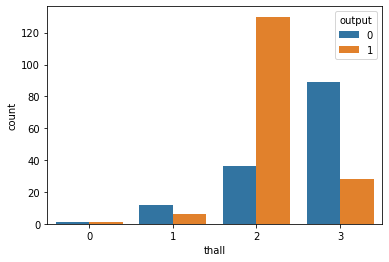

In [35]:
# sns.countplot印長條圖
# sns.countplot(x=印直的,y=印橫的)
import seaborn as sns
sns.countplot(x=data["thall"], hue=data["output"])

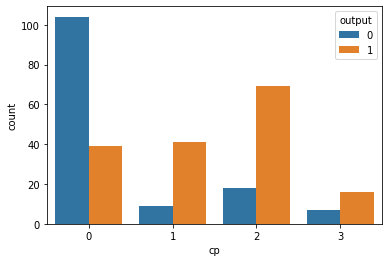

In [36]:
# sns.countplot印長條圖
# sns.countplot(x=印直的,y=印橫的)
import seaborn as sns
sns.countplot(x=data["cp"], hue=data["output"])

In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train_s = sc.fit_transform(x_train)
x_test_s = sc.transform(x_test)

x_train_s = pd.DataFrame(x_train_s,columns=x_train.keys())
x_train_s


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,-0.138914,0.666198,1.023990,-0.077981,0.000221,2.400658,-1.037660,0.991099,-0.696814,-0.864145,0.940595,2.374318,-0.485363
1,-1.667398,-1.501054,1.023990,-2.093296,-0.888073,-0.416552,0.880891,1.248341,-0.696814,-0.864145,0.940595,-0.712696,-0.485363
2,1.280392,-1.501054,2.005951,1.041638,-0.377777,-0.416552,0.880891,-1.538447,-0.696814,1.355853,-2.261167,-0.712696,-0.485363
3,-0.248092,0.666198,2.005951,-0.749753,-1.133771,-0.416552,-1.037660,1.719951,-0.696814,-0.864145,-0.660286,-0.712696,-2.105339
4,-1.012334,-1.501054,-0.939931,0.369866,-0.188778,-0.416552,-1.037660,0.090752,1.435104,-0.693376,-0.660286,-0.712696,-0.485363
...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,-0.138914,-1.501054,1.023990,-0.189943,-0.566775,-0.416552,-1.037660,-1.495573,-0.696814,-0.864145,0.940595,-0.712696,-3.725316
253,-2.104108,0.666198,0.042029,-0.525829,-1.020372,-0.416552,0.880891,1.033972,-0.696814,-0.864145,0.940595,-0.712696,-0.485363
254,-1.121511,0.666198,1.023990,-0.637791,-0.377777,-0.416552,0.880891,0.819604,-0.696814,-0.864145,0.940595,-0.712696,-0.485363
255,0.952860,-1.501054,-0.939931,1.041638,3.043099,-0.416552,-1.037660,0.176499,-0.696814,2.551237,-0.660286,2.374318,1.134614


In [12]:
# 做one-hot, output變成兩欄：0 or 1
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)
y_test_cat

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [13]:
import keras 
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
classifier = Sequential()
callbacks = [
   EarlyStopping(patience=8, monitor = 'accuracy',restore_best_weights=True) 
]# monitor要根據model設定的loss or metrics設定

classifier.add(Dense(units = 8, kernel_initializer = 'uniform',input_dim =13, activation = 'relu'))
classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
# classifier.add(Dense(units = 2, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 2, kernel_initializer = 'uniform', activation = 'softmax'))
classifier.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 
classifier.fit(x_train_s, y_train_cat, batch_size = 8, epochs = 200,callbacks=callbacks)

Epoch 1/200
33/33 [==============================] - 3s 4ms/step - loss: 0.6927 - accuracy: 0.5331
Epoch 2/200
33/33 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.5953
Epoch 3/200
33/33 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.7977
Epoch 4/200
33/33 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.8405
Epoch 5/200
33/33 [==============================] - 0s 3ms/step - loss: 0.5944 - accuracy: 0.8288
Epoch 6/200
33/33 [==============================] - 0s 3ms/step - loss: 0.5332 - accuracy: 0.8405
Epoch 7/200
33/33 [==============================] - 0s 3ms/step - loss: 0.4825 - accuracy: 0.8521
Epoch 8/200
33/33 [==============================] - 0s 3ms/step - loss: 0.4418 - accuracy: 0.8521
Epoch 9/200
33/33 [==============================] - 0s 3ms/step - loss: 0.4085 - accuracy: 0.8521
Epoch 10/200
33/33 [==============================] - 0s 3ms/step - loss: 0.3854 - accuracy: 0.8482
Epoch 11/

In [16]:
y_pred = classifier.predict(x_test_s)
# y_pred = (y_pred * (max(y_train) - min(y_train))) + min(y_train)
# print(y_pred)
def pred(y_pred):
  ans = []
  for i in y_pred:
    if i[0]>i[1]:
      ans.append(0) 
    else: 
      ans.append(1) 
  return ans
result = pd.DataFrame()


result['actual'] = y_test
result['predict'] = pred(x_test_s)

result



2/2 [==============================] - 0s 7ms/step


,actual,predict
92,1,1
88,1,0
64,1,1
140,1,0
143,1,0
180,0,1
105,1,0
74,1,0
14,1,0
208,0,1
